<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/dataPreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


## Data Pre-Processing

In [1]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]

# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [2]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()

,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [3]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

# SPLIT DATA (BEFORE SCALING)
# We define the split points using the raw data length
n = len(df)
train_size = int(n * 0.70)
val_size = int(n * 0.15)

# Split the raw DataFrame
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size : train_size + val_size]
test_df = df.iloc[train_size + val_size :]

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Check for outliers to determine what type of Scaling we should use
# target column
data = df['DE_load_actual_entsoe_transparency']

# If Z-Score outliers are > 0%, MinMax scaling might squash our 'normal' data
# Any point more than 3 Standard Deviations from the mean is considered an outlier
mean = np.mean(data)
std = np.std(data)
z_scores = (data - mean) / std
outliers_z = np.sum(np.abs(z_scores) > 3)
pct_z = (outliers_z / len(data)) * 100

print(f"Total Data Points: {len(data)}")
print(f"Outliers (Z-Score > 3): {outliers_z} ({pct_z:.2f}%)")

Total Data Points: 2882
Outliers (Z-Score > 3): 0 (0.00%)


In [5]:
from sklearn.preprocessing import StandardScaler

# SCALING (FIT ON TRAIN ONLY)
# Even though there are no outliers, we will use standard scalar to make the model
#robust for future unexpected outliers and to center the data for Relu activation function
scaler = StandardScaler()

# FIT only on Training data
scaler.fit(train_df)

# TRANSFORM all sets using the training statistics
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [6]:
# CREATE WINDOWS
def create_sliding_windows(data, window_size, target_idx):
    X_list, y_list = [], []
    for i in range(len(data) - window_size):
        # Input: Past 'window_size' steps
        X_list.append(data[i : i + window_size])
        # Target: The very next step (at index i + window_size)
        y_list.append(data[i + window_size, target_idx])
    return np.array(X_list), np.array(y_list)

# Define params
WINDOW_SIZE = 24
TARGET_COL_NAME = "DE_load_actual_entsoe_transparency"
target_idx = df.columns.get_loc(TARGET_COL_NAME)

# Create sets
X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE, target_idx)
X_val, y_val = create_sliding_windows(val_scaled, WINDOW_SIZE, target_idx)
X_test, y_test = create_sliding_windows(test_scaled, WINDOW_SIZE, target_idx)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (1993, 24, 6)
Test shape:  (409, 24, 6)


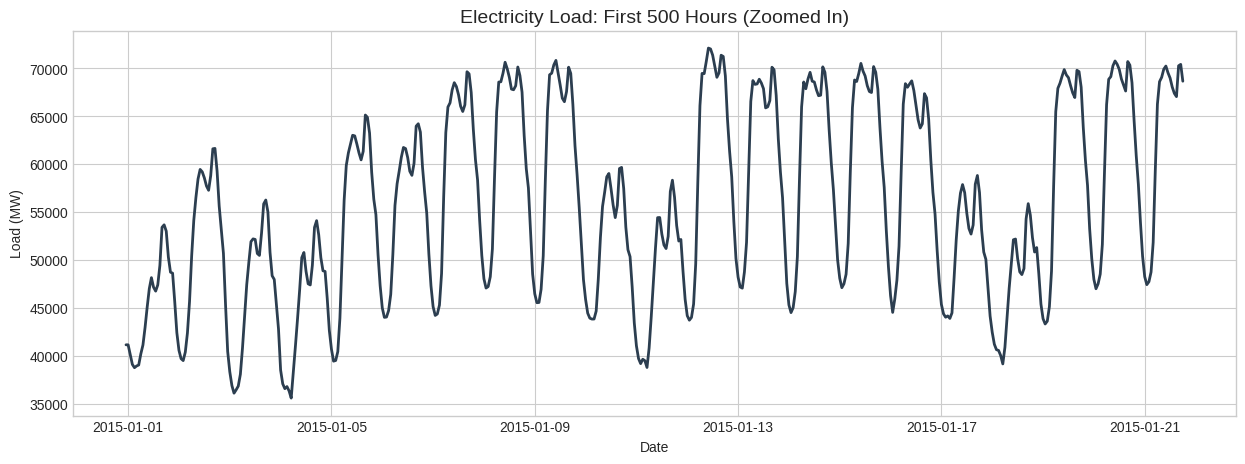

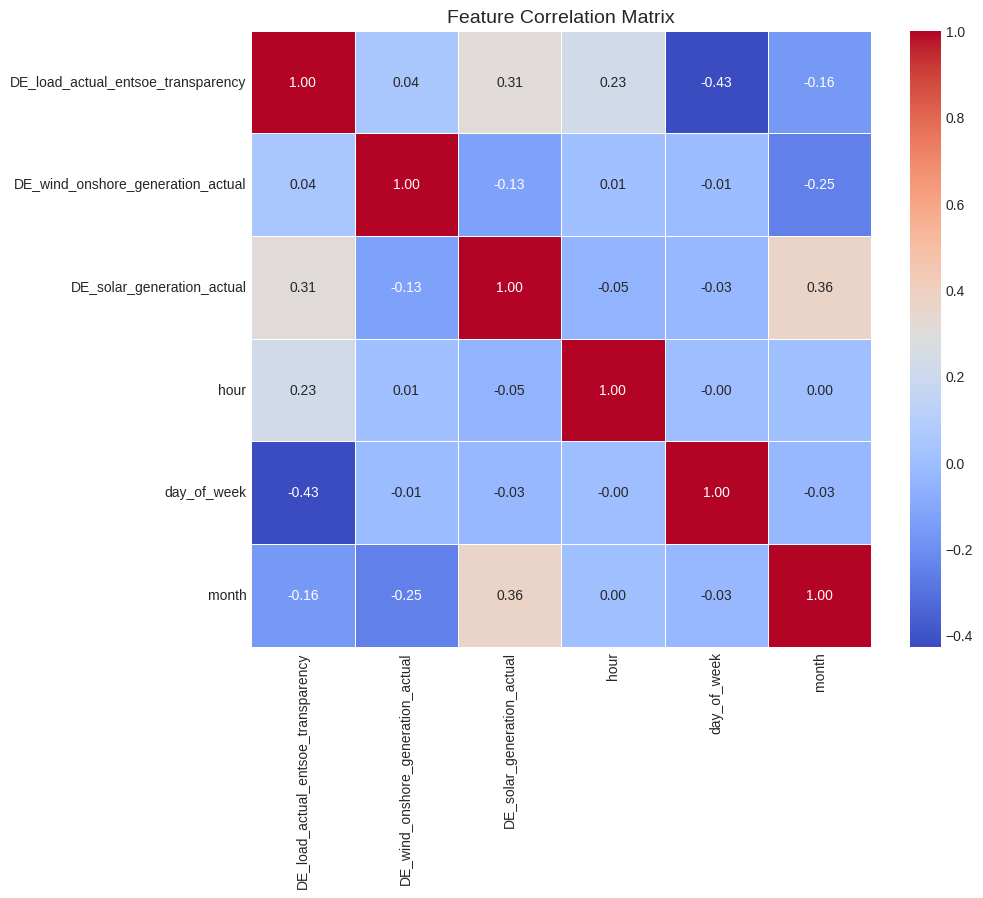

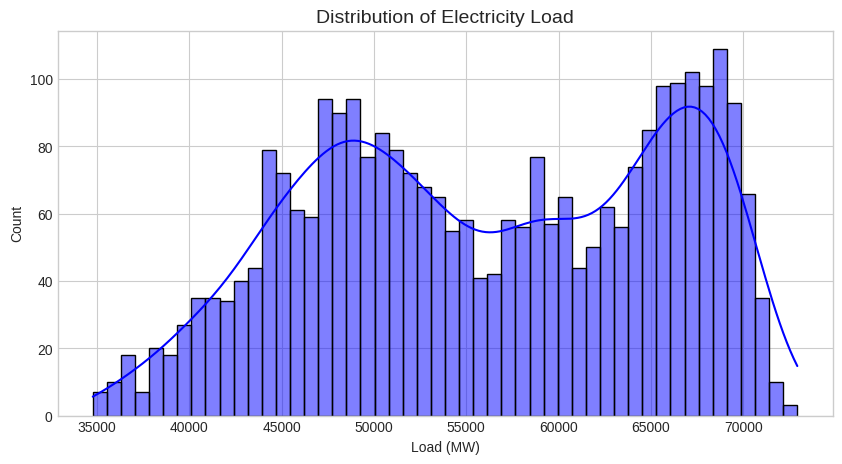

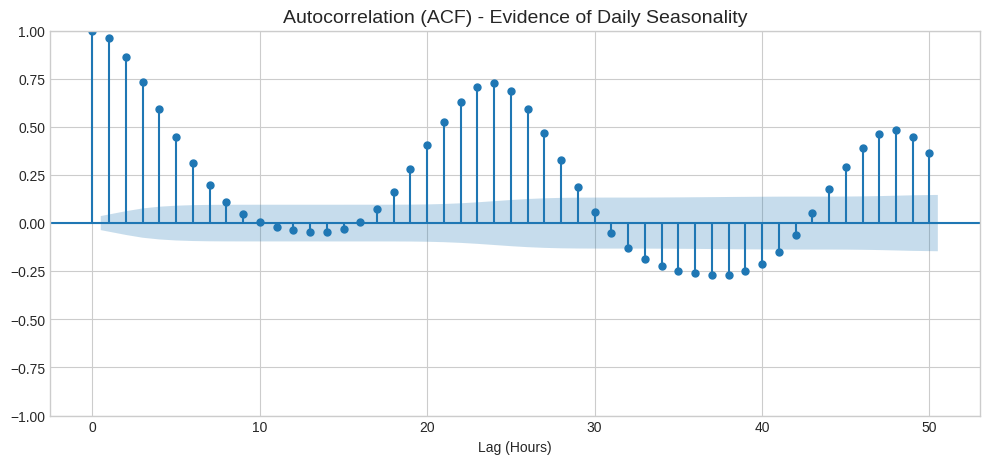

/tmp/ipython-input-3684477058.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")


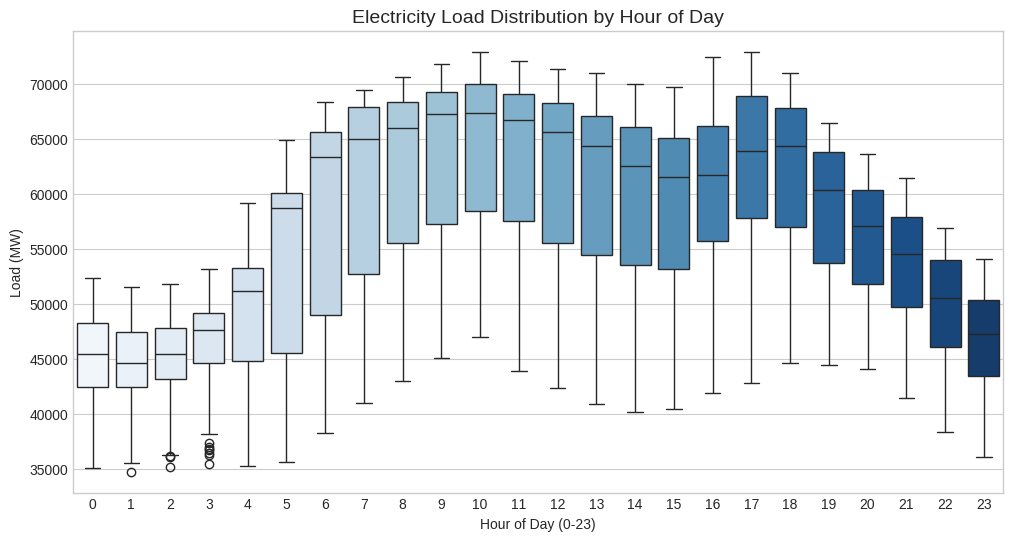

In [7]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Plot - Target Variable Over Time
plt.figure(figsize=(15, 5))
# Plot just the first 500 hours to make the pattern visible
plt.plot(df.index[:500], df['DE_load_actual_entsoe_transparency'][:500], color='#2c3e50', linewidth=2)
plt.title('Electricity Load: First 500 Hours (Zoomed In)', fontsize=14)
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
# Calculate correlation matrix
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

# Distribution of the Target (Normality Check)
# Justifies using StandardScaler. If this looks like a Bell Curve, Standard Scaling is the mathematically correct choice.
plt.figure(figsize=(10, 5))
sns.histplot(df['DE_load_actual_entsoe_transparency'], kde=True, color='blue', bins=50)
plt.title('Distribution of Electricity Load', fontsize=14)
plt.xlabel('Load (MW)')
plt.show()

# Autocorrelation Plot (ACF)
# Justifies our Window Size. It shows how correlated the present is with the past.
# We will likely see a spike at lag 24, proving the daily cycle.
plt.figure(figsize=(12, 5))
plot_acf(df['DE_load_actual_entsoe_transparency'], lags=50, ax=plt.gca())
plt.title('Autocorrelation (ACF) - Evidence of Daily Seasonality', fontsize=14)
plt.xlabel('Lag (Hours)')
plt.show()

# Boxplot by Hour of Day
# Shows the "Shape" of a typical day.
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")
plt.title('Electricity Load Distribution by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Load (MW)')
plt.show()


Starting GRU Optimization Experiment...
Testing Units: 32 | Val MAE: 0.28883
Testing Units: 64 | Val MAE: 0.25478
Testing Units: 128 | Val MAE: 0.19610
Optimization Complete. Best Configuration: 128 units

Training Best Multi-variate GRU Model (128 Units)...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.4589 - mae: 0.5425 - val_loss: 0.1285 - val_mae: 0.2822 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0890 - mae: 0.2399 - val_loss: 0.1024 - val_mae: 0.2592 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0696 - mae: 0.2098 - val_loss: 0.0921 - val_mae: 0.2400 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0581 - mae: 0.1913 - val_loss: 0.0817 - val_mae: 0.2216 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0564 - mae: 0.1881 - val_loss: 0.0812 - val_mae: 0.2256 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━

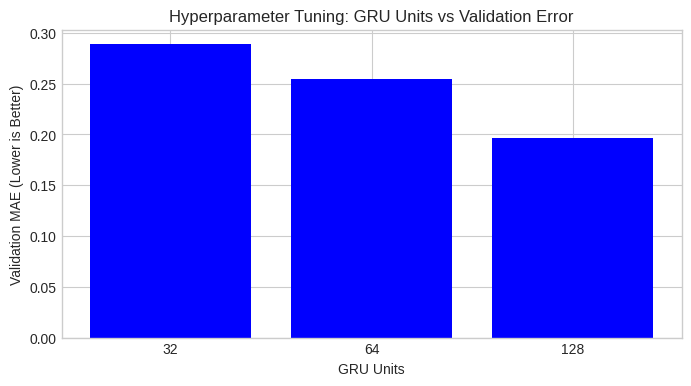

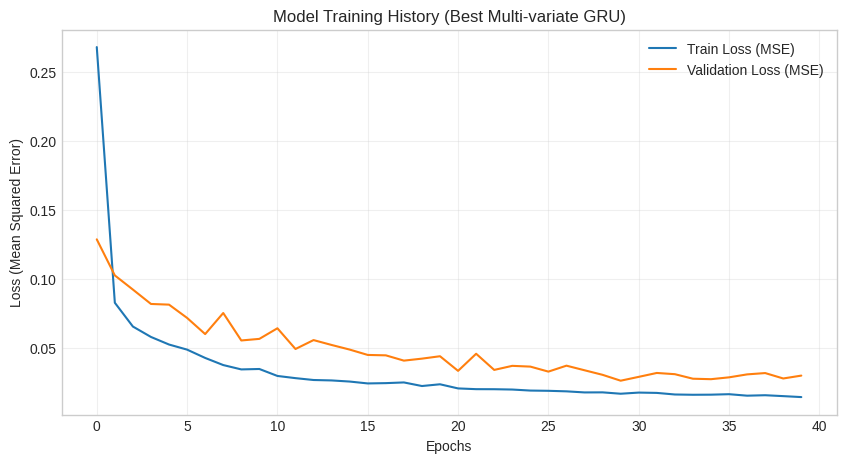

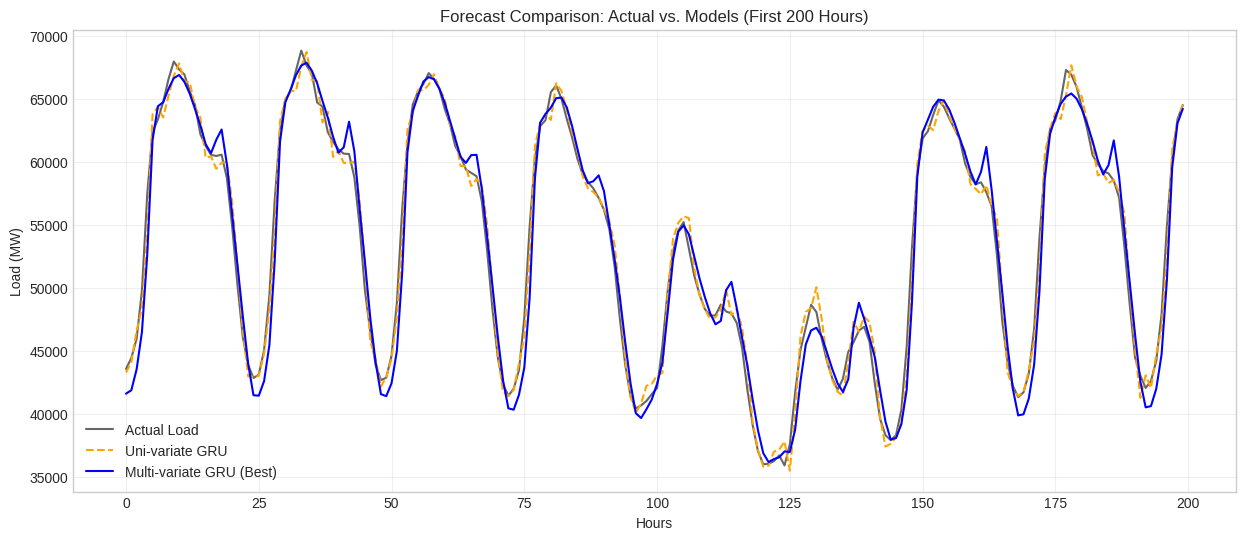

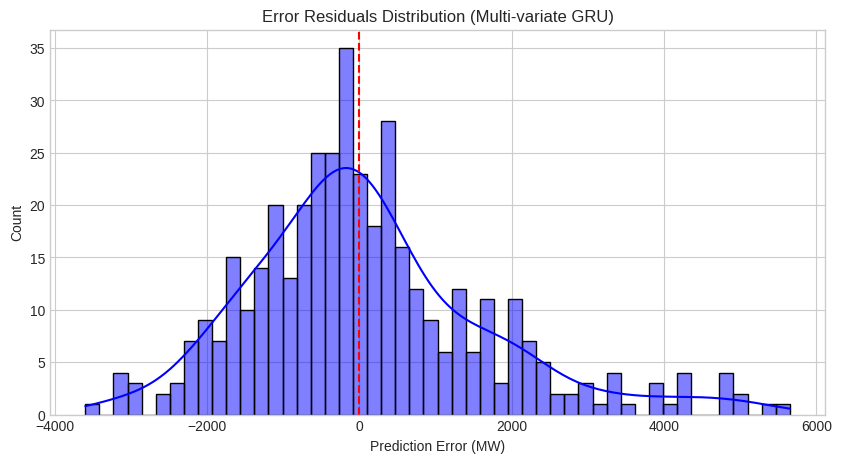

Mean Residual: 100.71 MW (Bias)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dynamically determine window size and feature count from the preprocessed data
# This ensures compatibility with the group's previous data loading steps
SEQ_LENGTH = X_train.shape[1]
N_FEATURES = X_train.shape[2]

# Helper function to generate sequences for the univariate baseline
# Defined locally to ensure availability in this cell scope
def create_sequences_local(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Hyperparameter Optimization Experiment
# Tests different GRU unit sizes to identify the architecture minimizing validation error
print("\nStarting GRU Optimization Experiment...")

def build_gru_model(input_shape, units=64, dropout=0.2):
    # Constructs a stacked GRU architecture with dropout for regularization
    model = Sequential([
        Input(shape=input_shape),
        GRU(units=units, return_sequences=True),
        Dropout(dropout),
        GRU(units=units // 2, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

unit_options = [32, 64, 128]
optimization_results = {}
best_mae = float('inf')
best_units = 64

for units in unit_options:
    model = build_gru_model((SEQ_LENGTH, N_FEATURES), units=units)

    # Train for a limited number of epochs to assess convergence speed
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        verbose=0
    )

    val_mae = history.history['val_mae'][-1]
    optimization_results[str(units)] = val_mae
    print(f"Testing Units: {units} | Val MAE: {val_mae:.5f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_units = units

print(f"Optimization Complete. Best Configuration: {best_units} units")

# Train Best Multi-variate GRU Model
# Retrains the model using the optimal unit size found in the previous step
print(f"\nTraining Best Multi-variate GRU Model ({best_units} Units)...")

best_model = build_gru_model((SEQ_LENGTH, N_FEATURES), units=best_units)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Uni-variate Baseline Training
# Trains a separate model using only the target variable (load) for comparison
print("\nTraining Uni-variate Baseline (Load Only)...")

# Extract the target column (index 0) from the scaled datasets
train_uni = train_scaled[:, 0:1]
val_uni = val_scaled[:, 0:1]
test_uni = test_scaled[:, 0:1]

X_train_u, y_train_u = create_sequences_local(train_uni, SEQ_LENGTH)
X_val_u, y_val_u = create_sequences_local(val_uni, SEQ_LENGTH)
X_test_u, y_test_u = create_sequences_local(test_uni, SEQ_LENGTH)

uni_model = build_gru_model((SEQ_LENGTH, 1), units=best_units)

uni_history = uni_model.fit(
    X_train_u, y_train_u,
    validation_data=(X_val_u, y_val_u),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# Evaluation and Visualization
# Generate predictions for both models on the test set
pred_multi_scaled = best_model.predict(X_test)
pred_uni_scaled = uni_model.predict(X_test_u)

# Inverse transform predictions to original scale (Megawatts)
# Uses a dummy array to match the scaler's expected input shape
def inverse_transform_target(pred_scaled, scaler, n_features):
    dummy = np.zeros((len(pred_scaled), n_features))
    dummy[:, 0] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

# Perform inverse transformation
y_test_real = inverse_transform_target(y_test.reshape(-1, 1), scaler, N_FEATURES)
pred_multi_real = inverse_transform_target(pred_multi_scaled, scaler, N_FEATURES)
pred_uni_real = inverse_transform_target(pred_uni_scaled, scaler, N_FEATURES)

# Calculate final error metrics (MAE and RMSE)
mae_m = mean_absolute_error(y_test_real, pred_multi_real)
rmse_m = np.sqrt(mean_squared_error(y_test_real, pred_multi_real))
mae_u = mean_absolute_error(y_test_real, pred_uni_real)
rmse_u = np.sqrt(mean_squared_error(y_test_real, pred_uni_real))

print("\nFinal Results Comparison:")
print(f"Uni-variate GRU  : MAE={mae_u:.2f} MW | RMSE={rmse_u:.2f} MW")
print(f"Multi-variate GRU: MAE={mae_m:.2f} MW | RMSE={rmse_m:.2f} MW")

improvement = ((mae_u - mae_m) / mae_u) * 100
print(f"Improvement: {improvement:.2f}%")

# Plot 1: Optimization Results (Bar Chart)
# Visualizes the validation error across different unit configurations
plt.figure(figsize=(8, 4))
plt.bar(optimization_results.keys(), optimization_results.values(), color=['blue', 'blue', 'blue'])
plt.title('Hyperparameter Tuning: GRU Units vs Validation Error')
plt.xlabel('GRU Units')
plt.ylabel('Validation MAE (Lower is Better)')
plt.show()

# Plot 2: Training History (Loss Curves)
# Shows the convergence of training and validation loss to verify no overfitting
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Train Loss (MSE)')
plt.plot(history_best.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Training History (Best Multi-variate GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: Forecast Comparison
# Visual comparison of the first 200 hours of predictions against actual load
plt.figure(figsize=(15, 6))
slice_range = slice(0, 200)
plt.plot(y_test_real[slice_range], label='Actual Load', color='black', alpha=0.6)
plt.plot(pred_uni_real[slice_range], label='Uni-variate GRU', color='orange', linestyle='--')
plt.plot(pred_multi_real[slice_range], label='Multi-variate GRU (Best)', color='blue')
plt.title('Forecast Comparison: Actual vs. Models (First 200 Hours)')
plt.ylabel('Load (MW)')
plt.xlabel('Hours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 4: Residual Analysis (Histogram)
# Displays the distribution of prediction errors to identify potential bias
errors = y_test_real - pred_multi_real
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='blue', bins=50)
plt.title('Error Residuals Distribution (Multi-variate GRU)')
plt.xlabel('Prediction Error (MW)')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

print(f"Mean Residual: {np.mean(errors):.2f} MW (Bias)")